<a href="https://colab.research.google.com/github/edumntg/OPF-python/blob/main/Pyomo_OPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -q pyomo

In [2]:
#!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
#!unzip -o -q ipopt-linux64

In [3]:
from pyomo.environ import *
from pyomo.environ import (
    ConcreteModel, Set, Var, Reals, Objective, Constraint, minimize, SolverFactory, value
)
import numpy as np
from math import pi

In [4]:
#!pip install gurobipy

# Data

In [5]:
Sbase = 10 # MW

buses = {
    1: [1, 0, 1.00, 0.0, 0.0, 0.0, 0.0, 0.0],
    2: [2, 1, 1.01, 0.0, 0.0, 0.0, 0.0, 0.0],
    3: [3, 2, 1.00, 0.0, 0.0, 0.0, 0.3, 0.1]
}

lines = {
    1: [1, 2, 0.0192, 0.0575, 0.0264, 1, 30/Sbase],
    2: [1, 3, 0.0452, 0.1852, 0.0204, 1, 30/Sbase],
    3: [2, 3, 0.0570, 0.1737, 0.0184, 1, 30/Sbase]
}

gens = {
    1: [1, 0/Sbase, 20/Sbase, -20/Sbase, 100/Sbase, 0.00375, 2, 0],
    2: [2, 0/Sbase, 20/Sbase, -20/Sbase, 100/Sbase, 0.0175, 1.75, 0]
}

# Create Ybus

In [6]:
nb = len(buses)
nl = len(lines)
ng = len(gens)

Ybus = np.zeros((nb, nb), dtype=np.complex128)
g = np.zeros((nb, nb))
b = np.zeros((nb,nb))
# Loop through lines
for lineid, linedata in lines.items():
  i = linedata[0]-1
  k = linedata[1]-1
  Z = linedata[2] + 1j*linedata[3]
  Bs = 1j*linedata[4]
  a = linedata[5]

  Ybus[i][i] += (1/(Z*a**2))
  Ybus[k][k] += (1/(Z*a**2))

  Ybus[i][i] += Bs
  Ybus[k][k] += Bs

  Ybus[i][k] -= 1/(a*Z)
  Ybus[k][i] -= 1/(a*Z)

  b[i][k] = Bs.imag
  b[k][i] = Bs.imag

G = Ybus.real
B = Ybus.imag

print(Ybus)
print(G)
print(B)

[[ 6.46838347-20.69594776j -5.22464618+15.64672684j
  -1.24373729 +5.09602092j]
 [-5.22464618+15.64672684j  6.9301765 -20.79930607j
  -1.70553032 +5.19737923j]
 [-1.24373729 +5.09602092j -1.70553032 +5.19737923j
   2.9492676 -10.25460015j]]
[[ 6.46838347 -5.22464618 -1.24373729]
 [-5.22464618  6.9301765  -1.70553032]
 [-1.24373729 -1.70553032  2.9492676 ]]
[[-20.69594776  15.64672684   5.09602092]
 [ 15.64672684 -20.79930607   5.19737923]
 [  5.09602092   5.19737923 -10.25460015]]


# Objective Function

In [7]:
def ObjectiveFunction(model):
  Cost = 0.0
  for genid, gendata in gens.items():
    bus = gendata[0]
    a = gendata[4]
    b = gendata[5]
    c = gendata[6]

    Cost += c*model.Pgen[bus]**2 + b*model.Pgen[bus] + a

  return Cost
  #return -sum(model.l[i] for i in model.bus)

# Constraints

In [8]:
def MinGen_P(model, bus):
  keys = [key for (key, v) in gens.items() if v[0] == bus]
  lb = 0
  if keys:
    lb = gens[keys[0]][1]
    
  return model.Pgen[bus] >= lb
  
def MaxGen_P(model, bus):
  keys = [key for (key, v) in gens.items() if v[0] == bus]
  ub = 0
  if keys:
    ub = gens[keys[0]][2]
    
  return model.Pgen[bus] <= ub

def MinGen_Q(model, bus):
  keys = [key for (key, v) in gens.items() if v[0] == bus]
  lb = 0
  if keys:
    lb = gens[keys[0]][3]
    
  return model.Qgen[bus] >= lb
  
def MaxGen_Q(model, bus):
  keys = [key for (key, v) in gens.items() if v[0] == bus]
  ub = 0
  if keys:
    ub = gens[keys[0]][4]
    
  return model.Qgen[bus] <= ub

def MaxFlowLineik(model, line):
  S = lines[line][6]
  i = lines[line][0]
  k = lines[line][1]
  return model.Pflow[i,k]**2+model.Qflow[i,k]**2 <= S

def MaxFlowLineki(model, line):
  S = lines[line][6]
  i = lines[line][1]
  k = lines[line][0]
  return model.Pflow[i,k]**2+model.Qflow[i,k]**2 <= S

def KirchoffBusesP(model, bus):
  Pik = 0
  Pgbus = model.Pgen[bus]
    
  for linea in model.line:
    i = lines[linea][0]
    if i == bus: # gen id is the same as bus id
      j = lines[linea][1]
      Pik += model.Pflow[i,j]
      
  for linea in model.line:
    i = lines[linea][1]
    if i == bus: # gen id is the same as bus id
      j = lines[linea][0]
      Pik += model.Pflow[i,j]
    
  return Pgbus == buses[bus][6] + Pik

def KirchoffBusesQ(model, bus):
  Qik = 0
  Qgbus = model.Qgen[bus]
  Qshunt = 0
  for linea in model.line:
    i = lines[linea][0]
    if i == bus: # gen id is the same as bus id
      j = lines[linea][1]
      Qik += model.Qflow[i,j]
      
  for linea in model.line:
    i = lines[linea][1]
    if i == bus: # gen id is the same as bus id
      j = lines[linea][0]
      Qik += model.Qflow[i,j]
      
    
  return Qgbus == buses[bus][7] + Qik + Qshunt
  
# Lines equations
def Pflow_square_like_original(model, linea):
    i = lines[linea][0]
    j = lines[linea][1]

    Vi2 = model.VR[i]**2 + model.VI[i]**2
    cos_term = model.VR[i]*model.VR[j] + model.VI[i]*model.VI[j]
    sin_term = model.VI[i]*model.VR[j] - model.VR[i]*model.VI[j]

    return model.Pflow[i, j] == (
        (-G[i-1][j-1] + g[i-1][j-1]) * Vi2
        + G[i-1][j-1] * cos_term
        + B[i-1][j-1] * sin_term
    )

def Qflow_square_like_original(model, linea):
    i = lines[linea][0]
    j = lines[linea][1]

    Vi2 = model.VR[i]**2 + model.VI[i]**2
    cos_term = model.VR[i]*model.VR[j] + model.VI[i]*model.VI[j]
    sin_term = model.VI[i]*model.VR[j] - model.VR[i]*model.VI[j]

    return model.Qflow[i, j] == (
        (B[i-1][j-1] - b[i-1][j-1]) * Vi2
        + (-B[i-1][j-1]) * cos_term
        + G[i-1][j-1] * sin_term
    )

def Pflow_square_like_original_rev(model, linea):
    i = lines[linea][1]
    j = lines[linea][0]
    Vi2 = model.VR[i]**2 + model.VI[i]**2
    cos_term = model.VR[i]*model.VR[j] + model.VI[i]*model.VI[j]
    sin_term = model.VI[i]*model.VR[j] - model.VR[i]*model.VI[j]
    return model.Pflow[i, j] == (
        (-G[i-1][j-1] + g[i-1][j-1]) * Vi2
        + G[i-1][j-1] * cos_term
        + B[i-1][j-1] * sin_term
    )

def Qflow_square_like_original_rev(model, linea):
    i = lines[linea][1]
    j = lines[linea][0]
    Vi2 = model.VR[i]**2 + model.VI[i]**2
    cos_term = model.VR[i]*model.VR[j] + model.VI[i]*model.VI[j]
    sin_term = model.VI[i]*model.VR[j] - model.VR[i]*model.VI[j]
    return model.Qflow[i, j] == (
        (B[i-1][j-1] - b[i-1][j-1]) * Vi2
        + (-B[i-1][j-1]) * cos_term
        + G[i-1][j-1] * sin_term
    )

def V_square_def(model, bus):
    return model.Vsq[bus] == model.VR[bus]**2 + model.VI[bus]**2



# Finally, solve

In [9]:
model = ConcreteModel()

model.bus = Set(initialize = buses.keys())
model.line = Set(initialize = lines.keys())
model.gen = Set(initialize = gens.keys())

# Create variables
model.Pgen = Var(model.bus, initialize = 0)
model.Qgen = Var(model.bus, initialize = 0)
model.VR = Var(model.bus, initialize = 1.0, bounds = (-1.1, 1.1))
model.VI = Var(model.bus, initialize = 1.0, bounds = (-1.1, 1.1))
model.Vsq = Var(model.bus, initialize = 1.0, bounds = (0.81, 1.21))

# Line flows
model.Pflow = Var(model.bus, model.bus)
model.Qflow = Var(model.bus, model.bus)

model.obj = Objective(rule = ObjectiveFunction, sense = minimize)

model.c0 = Constraint(expr = model.VI[1] == 0)

model.c1 = Constraint(model.bus, rule = KirchoffBusesP)
model.c2 = Constraint(model.bus, rule = KirchoffBusesQ)

model.c3 = Constraint(model.bus, rule = MaxGen_P)
model.c4 = Constraint(model.bus, rule = MinGen_P)
model.c5 = Constraint(model.bus, rule = MaxGen_Q)
model.c6 = Constraint(model.bus, rule = MinGen_Q)


model.c7 = Constraint(model.line, rule = MaxFlowLineik)
model.c8 = Constraint(model.line, rule = MaxFlowLineki)

model.c9 = Constraint(model.line, rule = Pflow_square_like_original)
model.c10 = Constraint(model.line, rule = Pflow_square_like_original_rev)
model.c11 = Constraint(model.line, rule = Qflow_square_like_original)
model.c12 = Constraint(model.line, rule = Qflow_square_like_original_rev)


# Solve

In [10]:
import gurobipy
from pyomo.environ import *
print(gurobipy.gurobi.version())
#solver = SolverFactory('ipopt', executable='/content/ipopt')
solver = SolverFactory('gurobi_direct')
#solver = SolverFactory('cyipopt')
results = solver.solve(model)
print(results.solver.termination_condition)

(13, 0, 1)
optimal


In [11]:
def PrintOPFACResults(model, buses, lineas, gens, shunts):

	nb = len(buses)
	nl = len(lineas)
	ng = len(gens)
	ns = len(shunts)

	print('BusID	VR	VI	Pg	Qg	l	Pl	Ql	Qshunt\n')
	l = {}
	for i in model.bus:
		Qshunt = 0
		Pg = abs(model.Pgen[i]())
		Qg = model.Qgen[i]()
		
		print("{0:.0f}	{1:.4f}	{2:.4f}	{3:.4f}	{4:.4f}	{5:.4f}	{6:.4f}	{7:.4f}	{8:.4f}".format(i,model.VR[i](),model.VI[i](),Pg,Qg, 1.0, buses[i][6], buses[i][7], 0.0))

	Pgtotal = sum(model.Pgen[i]() for i in model.bus)
	Qgtotal = sum(model.Qgen[i]() for i in model.bus)

	Ploadtotal = sum(buses[i][6] for i in model.bus)
	Qloadtotal = sum(buses[i][7] for i in model.bus)

	print("\n")
	print("TOTAL			{0:.4f}	{1:.4f}		{2:.4f}	{3:.4f}".format(Pgtotal, Qgtotal, Ploadtotal, Qloadtotal))
	print("\n\n")

	print("Busi	Busk	Pik	Pki	Qik	Qki")
	Pik = np.zeros((nb,nb))
	Pki = np.zeros((nb,nb))
	Qik = np.zeros((nb,nb))
	Qki = np.zeros((nb,nb))

	for l in model.line:
		i = lineas[l][0]
		j = lineas[l][1]
		print("{0:.0f}	{1:.0f}	{2:.4f}	{3:.4f}	{4:.4f}	{5:.4f}".format(i,j,model.Pflow[i,j](),model.Pflow[j,i](),model.Qflow[i,j](),model.Qflow[j,i]()))
		
	Ploss = 0
	Qloss = 0
	for l in model.line:
		i = lineas[l][0]
		j = lineas[l][1]
		Ploss += model.Pflow[i,j]() + model.Pflow[j,i]()
		Qloss += model.Qflow[i,j]() + model.Qflow[j,i]()


	Pl_supplied = sum(buses[i][6] for i in model.bus)
	Pl_total = sum(buses[i][6] for i in model.bus)
	perc_supplied = (Pl_supplied/Pl_total)*100
	
	print("\n")
	print("Total Ploss: {0:.4f}\nTotal Qloss: {1:.4f}".format(Ploss,Qloss))
	print("Total Load Supplied: {0:.4f}%".format(perc_supplied))

In [12]:
PrintOPFACResults(model, buses, lines, gens, [])

BusID	VR	VI	Pg	Qg	l	Pl	Ql	Qshunt

1	-1.1000	0.0000	0.1428	-0.0181	1.0000	0.0000	0.0000	0.0000
2	-1.0999	-0.0002	0.1592	-0.0316	1.0000	0.0000	0.0000	0.0000
3	-1.0879	0.0231	0.0000	0.0000	1.0000	0.3000	0.1000	0.0000


TOTAL			0.3020	-0.0497		0.3000	0.1000



Busi	Busk	Pik	Pki	Qik	Qki
1	2	-0.0033	0.0033	-0.0296	-0.0343
1	3	0.1461	-0.1453	0.0114	-0.0568
2	3	0.1559	-0.1547	0.0027	-0.0432


Total Ploss: 0.0020
Total Qloss: -0.1497
Total Load Supplied: 100.0000%


In [16]:
!pip install scipy

   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/41.3 MB ? eta -:--:--
   -- ------------------------------------- 2.1/41.3 MB 8.4 MB/s eta 0:00:05
   ---- ----------------------------------- 4.7/41.3 MB 9.5 MB/s eta 0:00:04
   ------- -------------------------------- 7.3/41.3 MB 10.5 MB/s eta 0:00:04
   --------- ------------------------------ 10.2/41.3 MB 11.2 MB/s eta 0:00:03
   ----------- ---------------------------- 12.3/41.3 MB 11.0 MB/s eta 0:00:03
   ------------- -------------------------- 14.2/41.3 MB 10.8 MB/s eta 0:00:03
   -------------- ------------------------- 15.2/41.3 MB 10.5 MB/s eta 0:00:03
   --------------- ------------------------ 15.7/41.3 MB 9.5 MB/s eta 0:00:03
   --------------- ------------------------ 16.3/41.3 MB 8.6 MB/s eta 0:00:03
   ---------------- ----------------------- 17.0/41.3 MB 8.0 MB/s eta 0:00:04
   ----------------- ---------------------- 17.6/41.3 MB 7.6 MB/s eta 0:00:04


In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

In [19]:
def draw_flow(ax, model, lines, flow_attr, pos, title, color_pos, color_neg):
    ax.set_title(title, fontsize=14, fontweight='bold')

    # 1) 画底图边（灰色拓扑）
    for line in model.line:
        i, j = lines[line][0], lines[line][1]
        ax.plot([pos[i][0], pos[j][0]], [pos[i][1], pos[j][1]],
                linewidth=1.0, alpha=0.35)

    # 2) 收集所有流用于归一化
    flows = []
    for line in model.line:
        i, j = lines[line][0], lines[line][1]
        f = getattr(model, flow_attr)[i, j]()
        flows.append(abs(f))
    fmax = max(flows) if flows else 1.0
    fmax = max(fmax, 1e-9)

    # 3) 只画一次方向箭头（按符号决定方向）
    for line in model.line:
        i, j = lines[line][0], lines[line][1]
        f = getattr(model, flow_attr)[i, j]()

        if f >= 0:
            u, v = i, j
            col = color_pos
        else:
            u, v = j, i
            col = color_neg

        lw = 1.5 + 3.5 * (abs(f) / fmax)   # 线宽限制在 ~[0.8, 5.8]
        arrow = FancyArrowPatch(pos[u], pos[v],
                                arrowstyle='->',
                                mutation_scale=14,
                                linewidth=lw,
                                color=col,
                                alpha=0.75,
                                connectionstyle="arc3,rad=0.05")
        ax.add_patch(arrow)

    # 4) 画节点（建议也归一化半径，否则看不出差别/或过大）
    Vs = []
    for bus in model.bus:
        V = (model.VR[bus]()**2 + model.VI[bus]()**2)**0.5
        Vs.append(V)
    Vmin, Vmax = min(Vs), max(Vs)
    span = max(Vmax - Vmin, 1e-6)

    for bus, V in zip(model.bus, Vs):
        r = 0.03 + 0.05 * ((V - Vmin) / span)   # 半径控制在 [0.03, 0.08]
        circle = plt.Circle(pos[bus], r, color='tab:blue', alpha=0.85, zorder=3)
        ax.add_patch(circle)
        ax.text(pos[bus][0], pos[bus][1], str(bus),
                ha='center', va='center', fontweight='bold', color='white', zorder=4)

    set_auto_limits(ax, pos, pad=0.25)
    ax.axis('off')


In [20]:
def set_auto_limits(ax, pos, pad=0.15):
    xs = np.array([pos[n][0] for n in pos])
    ys = np.array([pos[n][1] for n in pos])
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    dx = xmax - xmin
    dy = ymax - ymin
    ax.set_xlim(xmin - pad*dx, xmax + pad*dx)
    ax.set_ylim(ymin - pad*dy, ymax + pad*dy)

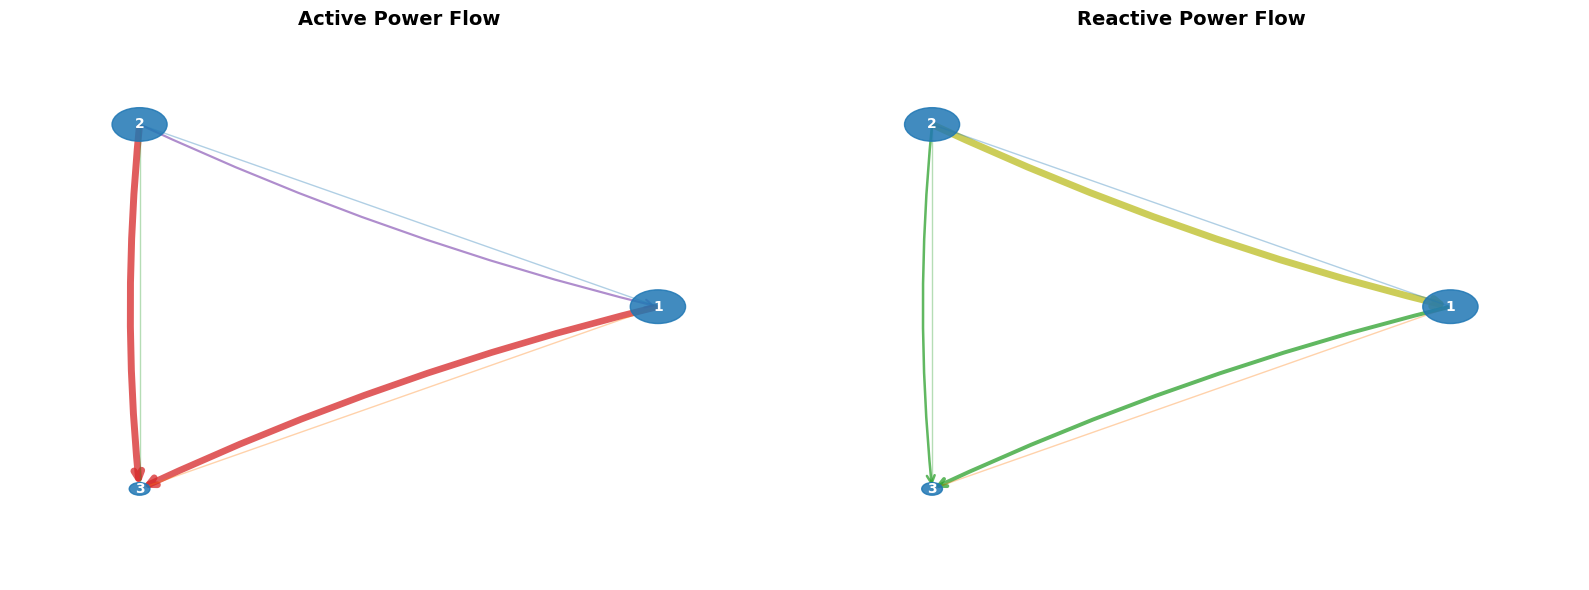

In [21]:
# ---- build graph ----
G = nx.Graph()
for bus in model.bus:
    G.add_node(bus)
for line in model.line:
    i, j = lines[line][0], lines[line][1]
    G.add_edge(i, j)

pos = nx.kamada_kawai_layout(G)   # 比 spring_layout 更稳

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

draw_flow(ax1, model, lines, "Pflow", pos, "Active Power Flow", "tab:red", "tab:purple")
draw_flow(ax2, model, lines, "Qflow", pos, "Reactive Power Flow", "tab:green", "tab:olive")

plt.tight_layout()
plt.show()